# Import Required Libraries

In [31]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
Load the dataset into a pandas DataFrame.

In [14]:

fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_data = pd.read_csv('../data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../data/creditcard.csv')
df.head()  

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


. Handle Missing Values

In [15]:
fraud_data.dropna(inplace=True)
creditcard_data.dropna(inplace=True)

#Data Cleaning

In [16]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
creditcard_data.drop_duplicates(inplace=True)

# Correct data types
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

#Exploratory Data Analysis (EDA)

In [17]:
print(fraud_data.describe())
print(creditcard_data.describe())

             user_id                    signup_time  \
count  151112.000000                         151112   
mean   200171.040970  2015-04-20 00:56:09.511329280   
min         2.000000            2015-01-01 00:00:42   
25%    100642.500000     2015-02-18 09:52:48.500000   
50%    199958.000000            2015-04-19 04:41:30   
75%    300054.000000  2015-06-18 14:47:22.750000128   
max    400000.000000            2015-08-18 04:40:29   
std    115369.285024                            NaN   

                       purchase_time  purchase_value            age  \
count                         151112   151112.000000  151112.000000   
mean   2015-06-16 02:56:38.759952896       36.935372      33.140704   
min              2015-01-01 00:00:44        9.000000      18.000000   
25%       2015-04-18 14:41:25.500000       22.000000      27.000000   
50%       2015-06-18 13:46:17.500000       35.000000      33.000000   
75%       2015-08-17 18:48:31.500000       49.000000      39.000000   
max    

In [21]:
# Select only numeric columns for correlation
numeric_fraud_data = fraud_data.select_dtypes(include=[np.number])
numeric_creditcard_data = creditcard_data.select_dtypes(include=[np.number])

# Calculate and print correlation matrices
print(numeric_fraud_data.corr())
print(numeric_creditcard_data.corr())

                 user_id  purchase_value       age  ip_address     class
user_id         1.000000        0.002617  0.000611   -0.003144  0.001945
purchase_value  0.002617        1.000000  0.002370   -0.000328  0.001011
age             0.000611        0.002370  1.000000    0.001140  0.006624
ip_address     -0.003144       -0.000328  0.001140    1.000000 -0.005208
class           0.001945        0.001011  0.006624   -0.005208  1.000000
            Time        V1        V2        V3        V4        V5        V6  \
Time    1.000000  0.117927 -0.010556 -0.422054 -0.105845  0.173223 -0.063279   
V1      0.117927  1.000000  0.006875 -0.008112  0.002257 -0.007036  0.000413   
V2     -0.010556  0.006875  1.000000  0.005278 -0.001495  0.005210 -0.000594   
V3     -0.422054 -0.008112  0.005278  1.000000  0.002829 -0.006879 -0.001511   
V4     -0.105845  0.002257 -0.001495  0.002829  1.000000  0.001744 -0.000880   
V5      0.173223 -0.007036  0.005210 -0.006879  0.001744  1.000000 -0.000938   
V6

In [23]:
# Convert IP addresses to integer format, handling missing or non-string values
fraud_data['ip_address'] = fraud_data['ip_address'].apply(lambda x: int(str(x).replace('.', '')) if pd.notnull(x) else np.nan)
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].apply(lambda x: int(str(x).replace('.', '')) if pd.notnull(x) else np.nan)
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].apply(lambda x: int(str(x).replace('.', '')) if pd.notnull(x) else np.nan)

In [24]:
merged_data = pd.merge(fraud_data, ip_data, how='left', left_on='ip_address', right_on='lower_bound_ip_address')

In [25]:
fraud_data['transaction_frequency'] = fraud_data.groupby('user_id')['purchase_time'].transform('count')
fraud_data['transaction_velocity'] = fraud_data.groupby('user_id')['purchase_time'].transform(lambda x: (x.max() - x.min()).days)

In [26]:
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek

In [27]:
scaler = StandardScaler()
fraud_data[['purchase_value', 'transaction_frequency', 'transaction_velocity']] = scaler.fit_transform(fraud_data[['purchase_value', 'transaction_frequency', 'transaction_velocity']])
creditcard_data[['Amount']] = scaler.fit_transform(creditcard_data[['Amount']])

Encode Categorical Features

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
fraud_data['source'] = label_encoder.fit_transform(fraud_data['source'])
fraud_data['browser'] = label_encoder.fit_transform(fraud_data['browser'])
fraud_data['sex'] = label_encoder.fit_transform(fraud_data['sex'])

In [30]:
fraud_data.to_csv('../data/Preprocessed_Fraud_Data.csv', index=False)
creditcard_data.to_csv('../data/Preprocessed_Creditcard_Data.csv', index=False)

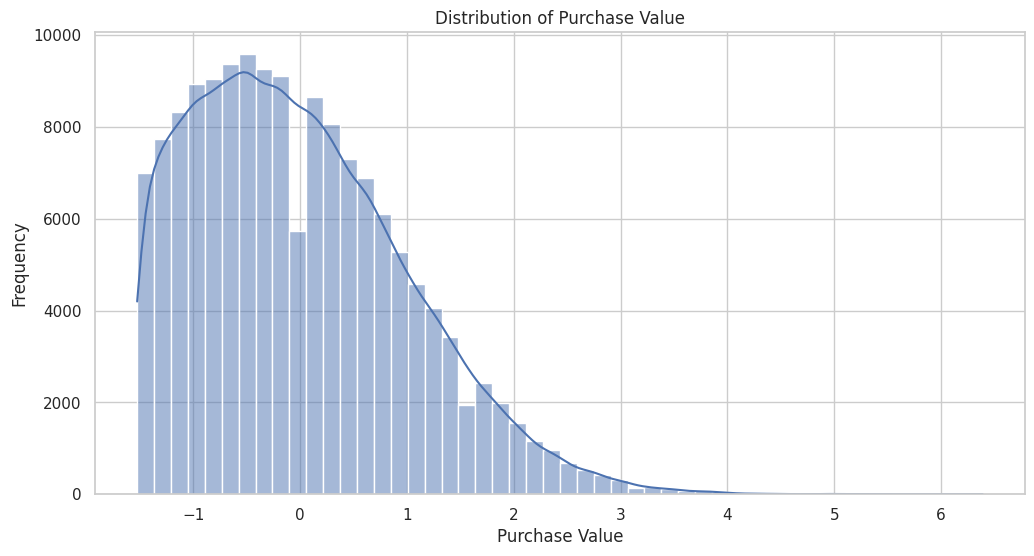

In [32]:
# Set up the visualizations
sns.set(style="whitegrid")

# Visualize the distribution of numerical features
plt.figure(figsize=(12, 6))
sns.histplot(fraud_data['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.show()

#Visualize the correlation matrix

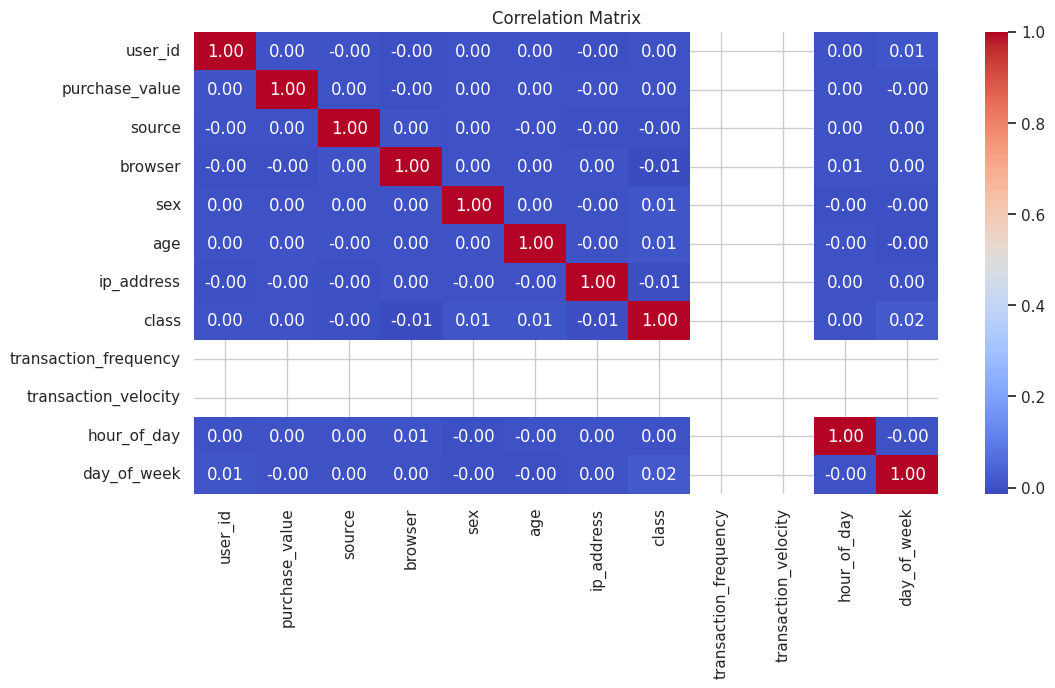

In [33]:
plt.figure(figsize=(12, 6))
corr_matrix = fraud_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Visualize categorical features

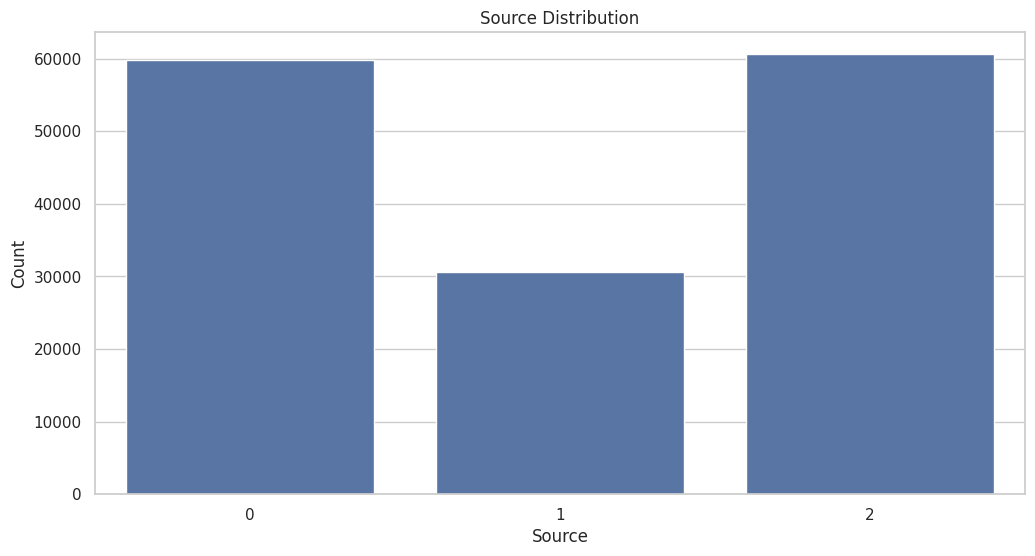

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='source')
plt.title('Source Distribution')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

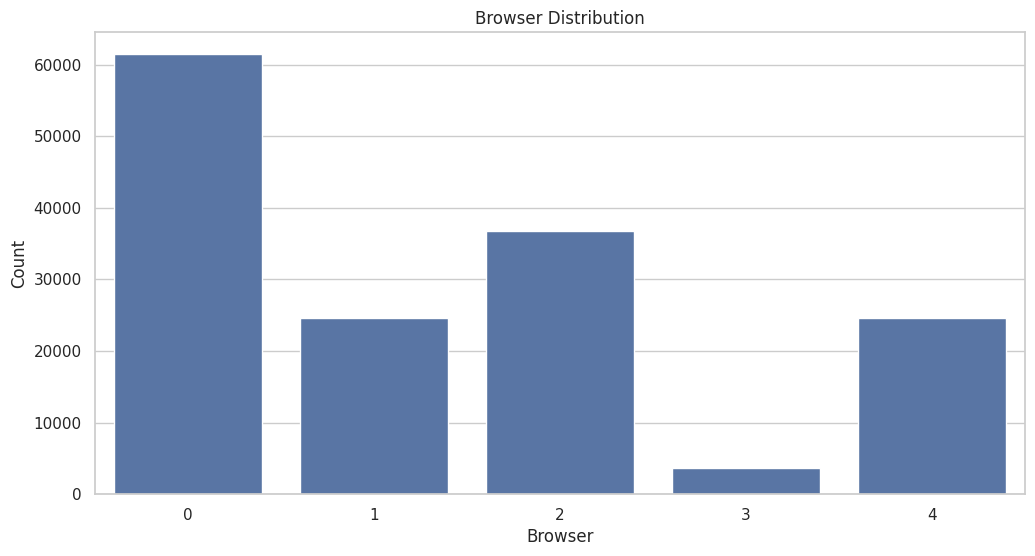

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='browser')
plt.title('Browser Distribution')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.show()

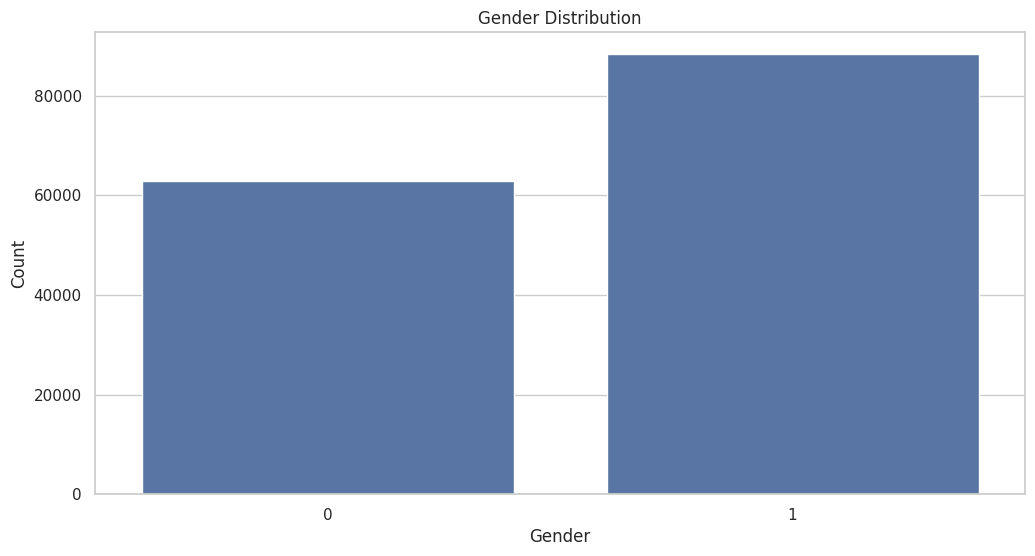

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='sex')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()